### Model Building 

In [1]:
# Import all libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing.text import Tokenizer
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Conv1D, MaxPooling1D,Layer,Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D, Add, RepeatVector, TimeDistributed,concatenate
from tensorflow.keras.models import Model, Sequential
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras.backend as K
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras import regularizers
#from tensorflow.compact.v1.keras.layers import Attention

Using TensorFlow backend.


from google.colab import drive
drive.mount('/content/drive')

In [2]:
df = pd.read_excel('D5(InputData)_processed_trimmed_data.xlsx',sheet_name='Sheet1',encoding="utf-8",dtype="str")

In [15]:
maxlen_s = 50
maxlen_l = 100
embedding_size = 200
numword1 = 6000
numword2 = 8000
numword3 = 13000

In [16]:
def prepare_token(data,numword):
  t = Tokenizer(num_words=numword)
  t.fit_on_texts(data)
  print("Tokenization process...F1.2..", len(t.word_index)) 
  return (t)

In [17]:
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()

In [18]:
def Glv_model(data,t):
  #print("Preparing GloVe vector...F1.3 .. token as input", len(t.word_index))
  embeddings = {}  
  if len(embeddings)==0:
    EMBEDDING_FILE = 'glove.6B.200d.txt'
    embeddings = dict()
    f = open(EMBEDDING_FILE,encoding='Latin-1')
    for line in (f):
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:])
        embeddings[word] = coefs
    f.close()
  print("Glove being used:",len(embeddings))
  
  word_index = t.word_index
  print("t.word_index shape", len(t.word_index))  
  embedding_matrix = np.zeros((t.num_words, embedding_size))
  #print("Embedding Matrix Shape : ", embedding_matrix.shape )
  for word, i in tqdm(word_index.items()):
    if i < t.num_words:
        embedding_vector = embeddings.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
            #if i < 2 : print(i,embedding_matrix[i])
  return(embedding_matrix)

In [19]:
#Tokenization and Embedding Process

#t1 = prepare_token(df["trimmed_words_short"],numword1)
#t2 = prepare_token(df["trimmed_words_long"],numword2)
t3 = prepare_token(df["trimmed_words_short"]+" "+df["trimmed_words_long"],numword3)

#embedding_matrix1 = Glv_model(df["trimmed_words_short"],t1)
#embedding_matrix2 = Glv_model(df["trimmed_words_long"],t2)
embedding_matrix3 = Glv_model(df["trimmed_words_short"]+" "+df["trimmed_words_long"],t3)



Tokenization process...F1.2.. 13923


  8%|▊         | 1117/13923 [00:00<00:01, 10742.27it/s]

Glove being used: 399955
t.word_index shape 13923


100%|██████████| 13923/13923 [00:00<00:00, 25231.24it/s]


In [20]:
len(df["trimmed_words_short"]+" "+df["trimmed_words_long"])

8373

In [21]:
#print(t1.num_words)
#print(len(t1.word_counts))
#print(t2.num_words)
#print(len(t2.word_counts))
print(t3.num_words)
print(len(t3.word_counts))



13000
13923


In [22]:
## Data Preparation
X_short_t = t3.texts_to_sequences(df["trimmed_words_short"])
X_long_t = t3.texts_to_sequences(df["trimmed_words_long"])
X_short = pad_sequences(X_short_t, maxlen=maxlen_s, padding = 'post', truncating = 'post')
X_long = pad_sequences(X_long_t, maxlen=maxlen_l, padding = 'post', truncating = 'post')

onehot_encoder = OneHotEncoder(sparse=False)
#values = np.array(values).reshape(len(values),1)
y = onehot_encoder.fit_transform(np.array(df["Assignment group"]).reshape(len(df["Assignment group"]),1))
y_75 = onehot_encoder.fit_transform(np.array(df["new_group_75"]).reshape(len(df["new_group_75"]),1))
y_85 = onehot_encoder.fit_transform(np.array(df["new_group_85"]).reshape(len(df["new_group_85"]),1))
y_95 = onehot_encoder.fit_transform(np.array(df["new_group_95"]).reshape(len(df["new_group_95"]),1))

Groups = len(df["Assignment group"].value_counts())
Groups_75 = len(df["new_group_75"].value_counts())
Groups_85 = len(df["new_group_85"].value_counts())
Groups_95 = len(df["new_group_95"].value_counts())

# Split features into training and validation sets
X_train_s, X_val_s, X_train_l,  X_val_l, y_train, y_val,y_train_75,y_val_75,y_train_85,y_val_85,y_train_95,y_val_95 = train_test_split(X_short,X_long,y,y_75,y_85,y_95, test_size=0.20, random_state=15)

print("X_train_s Shape : ",X_train_s.shape)
print("X_train_l Shape : ",X_train_l.shape)
print("y_train Shape : ",y_train.shape)
print("Group counts : ",Groups,Groups_75,Groups_85,Groups_95)


X_train_s Shape :  (6698, 50)
X_train_l Shape :  (6698, 100)
y_train Shape :  (6698, 74)
Group counts :  74 10 18 36


In [23]:
X_short[16],X_long[16],df["trimmed_words_short"][16]

(array([ 9, 20, 16, 46,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]),
 array([  48,    9,   20,   16,   46,  477,  183,   49,   35,  768,   65,
         165,   39,   66,  291,   22,  989,   19,  404,  990,  220,  584,
         508, 1662,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0]),
 'unable login company vpn')

In [24]:
df["new_group_85"].value_counts()

GRP_0       3954
GRP_9999    1174
GRP_8        661
GRP_24       289
GRP_12       257
GRP_9        252
GRP_2        241
GRP_19       213
GRP_3        200
GRP_6        184
GRP_13       144
GRP_10       139
GRP_5        129
GRP_14       118
GRP_25       116
GRP_33       106
GRP_4        100
GRP_29        96
Name: new_group_85, dtype: int64

In [25]:
## Build the Model

# Model with Short description..............
short_desc_input = Input(shape=(maxlen_s,), dtype='int32',name = "1.0_Input_Layer")
embedded_sequences = Embedding(t3.num_words, embedding_size,weights = [embedding_matrix3], trainable = False, name='1.1_Embedding')(short_desc_input)
short_lstm = Bidirectional(LSTM(50, return_sequences=True, dropout=0.2),name = "1.2_Bidirectional")(embedded_sequences)
#attn = attention()(short_lstm)
short_dense = TimeDistributed(Dense(50),name = "1.3_TimeDense")(short_lstm)
#attn = attention(name = "1.4_attention")(short_dense)
dropout1 = Dropout(0.3)(short_dense)
short_flatten = Flatten(name="1.5_Flatten")(dropout1)

# Model with Long description..............
long_input = Input(shape=(maxlen_l,), dtype='int32',name = "2.0_Input_Layer")
long_embedded_sequences = Embedding(t3.num_words, embedding_size,weights = [embedding_matrix3], trainable = False, name='2.1_Embedding')(long_input)
long_lstm = Bidirectional(LSTM(50, return_sequences=True, dropout = 0.2),name = "2.2_Bidirectional")(long_embedded_sequences)
long_dense = Dense(50, activation='relu',name = "2.3_Dense",
                   kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001))(long_lstm)
dropout2 = Dropout(0.3)(long_dense)
long_flatten = Flatten(name = "2.4_Flatten")(dropout2)

#Concate both the end Layers ....................
description_output = concatenate([short_flatten, long_flatten], name='3.1_concatenate_heading')
preds = Dense(10, activation='softmax',name = "3.3_Dense")(description_output)

#Final model and compiling.................
model = Model([short_desc_input, long_input], [preds])
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.001), metrics=['accuracy', 'mse'])
model.summary()  


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
1.0_Input_Layer (InputLayer)    [(None, 50)]         0                                            
__________________________________________________________________________________________________
2.0_Input_Layer (InputLayer)    [(None, 100)]        0                                            
__________________________________________________________________________________________________
1.1_Embedding (Embedding)       (None, 50, 200)      2600000     1.0_Input_Layer[0][0]            
__________________________________________________________________________________________________
2.1_Embedding (Embedding)       (None, 100, 200)     2600000     2.0_Input_Layer[0][0]            
____________________________________________________________________________________________

In [26]:
# Run the model....
reduce_lr = (ReduceLROnPlateau(monitor='val_acc', factor=0.1,
                              patience=1, min_lr=0.00000001))
early_stop = (EarlyStopping(monitor='val_acc', patience= 3))

history = model.fit([X_train_s,X_train_l], [y_train_75], 
                    validation_data=[[X_val_s,X_val_l],[y_val_75]], 
                    epochs=200, batch_size=4,callbacks= ([reduce_lr,early_stop]), verbose = 1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 6698 samples, validate on 1675 samples
Epoch 1/200
6698/6698 [==============================] - 596s 89ms/sample - loss: 1.2658 - acc: 0.6266 - mean_squared_error: 0.0506 - val_loss: 1.0369 - val_acc: 0.6645 - val_mean_squared_error: 0.0459
Epoch 2/200
6698/6698 [==============================] - 595s 89ms/sample - loss: 0.9320 - acc: 0.6848 - mean_squared_error: 0.0425 - val_loss: 0.9613 - val_acc: 0.6794 - val_mean_squared_error: 0.0436
Epoch 3/200
6698/6698 [==============================] - 567s 85ms/sample - loss: 0.8451 - acc: 0.7081 - mean_squared_error: 0.0396 - val_loss: 0.9333 - val_acc: 0.6860 - val_mean_squared_error: 0.0426
Epoch 4/200
6698/6698 [==============================] - 562s 84ms/sample - loss: 0.7845 - acc: 0.7292 - mean_squared_error: 0.0373 - val_loss: 0.9127 - val_acc: 0.6979 - val_mean_squared_error: 0.0416
Epoch 5/200
6698/6698 [===========================

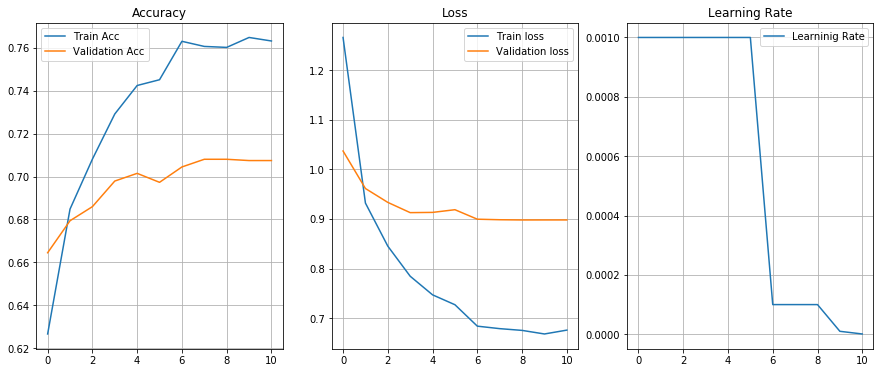

In [27]:
fig = plt.figure(figsize = (15, 6))
plt.subplot(1, 3, 1)
plt.plot(history.history['acc'], label='Train Acc')
plt.plot(history.history['val_acc'], label='Validation Acc')
#print("\n Data set : "+D+" & "+T+";  No of Output Groups: "+str(Groups)+" ; GloVe vector used : "+glv+"; Attention :"+attention1)
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.subplot(1, 3, 3)
plt.plot(history.history['lr'], label='Learninig Rate')
plt.title("Learning Rate")
plt.legend()
plt.grid()


plt.show()